# Import packages

In [2]:
# !pip install pmdarima==2.0.4 -q
# !pip uninstall -y numpy
# !pip install --no-cache-dir --force-reinstall numpy==1.26.4

# import os
# os._exit(00)

In [3]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")

# Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Useful Functions

In [5]:
# Function to assess model and visualize output

def model_assessment(train, test, predictions, chart_title):

  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))

  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")

  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

  return

# Function to plot the future

def plot_future(y, forecast, title):

  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))

  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")

  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

  return

# Load in the dataset

In [6]:
# Loading the daily revenue data and set the date as index
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Time Series Analysis/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX/daily_revenue.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)

# Fix format of columns
df['revenue'] = df['revenue'].str.replace(',', '').astype(float)
df['discount_rate'] = df['discount_rate'].str.replace('%', '').astype(float) / 100
df['coupon_rate'] = df['coupon_rate'].str.replace('%', '').astype(float) / 100

df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
dtypes: float64(3)
memory usage: 56.1 KB


(None,
               revenue  discount_rate  coupon_rate
 date                                             
 2018-01-01  6270839.0         0.3427       0.0109
 2018-01-02  8922076.0         0.3087       0.0108
 2018-01-03  8446101.0         0.2811       0.0101
 2018-01-04  7785798.0         0.2732       0.0096
 2018-01-05  6375303.0         0.2570       0.0090)

# Assign frequency of dataframe

In [7]:
df = df.asfreq('D')
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [8]:
df = df.rename(columns = {'revenue': 'y'})

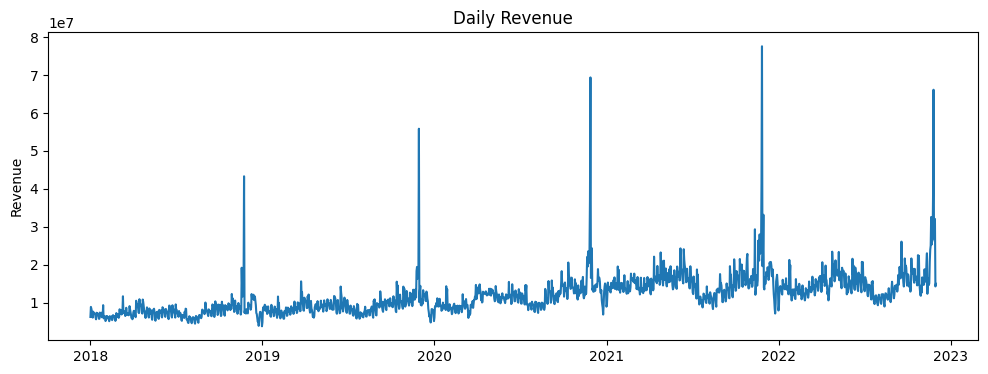

In [9]:
plt.figure(figsize = (12,4))
plt.plot(df['y'])
plt.title("Daily Revenue")
plt.ylabel("Revenue")
plt.show()

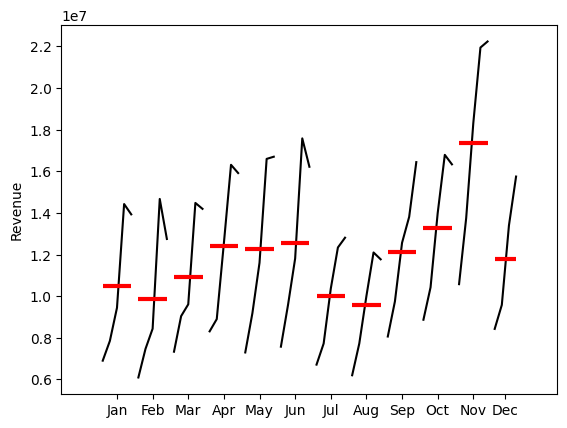

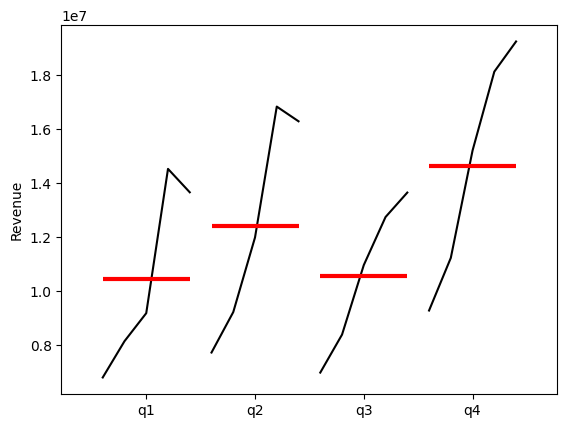

In [10]:
# Plot the monthly and quarterly seasonalities

month_plot(df['y'].resample('ME').mean())
plt.ylabel("Revenue")
plt.show()

quarter_plot(df['y'].resample('QE').mean())
plt.ylabel("Revenue")
plt.show()

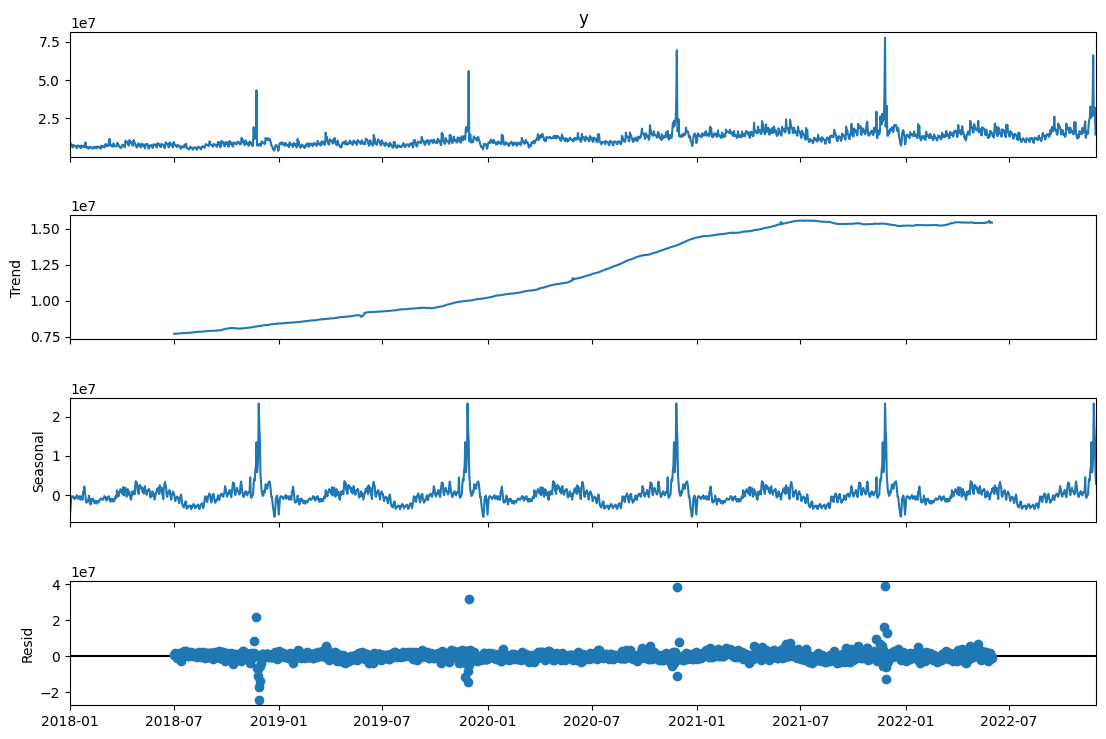

In [11]:
# Create the seasonal decomposition plots

result = seasonal_decompose(df['y'], model = 'additive', period=365)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()

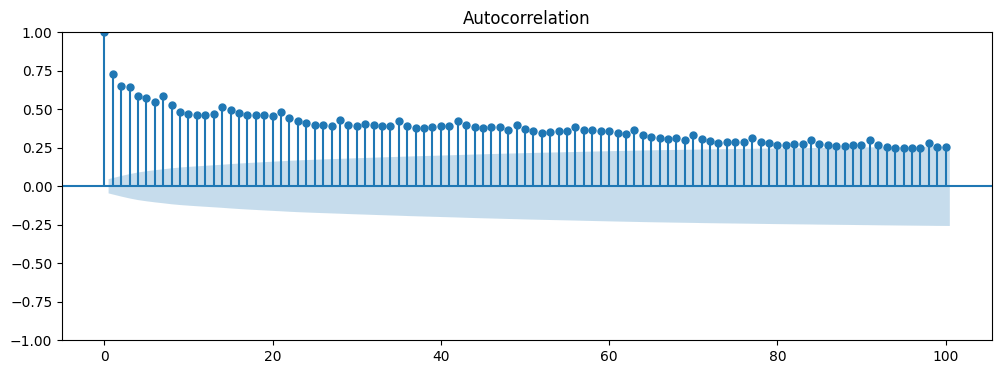

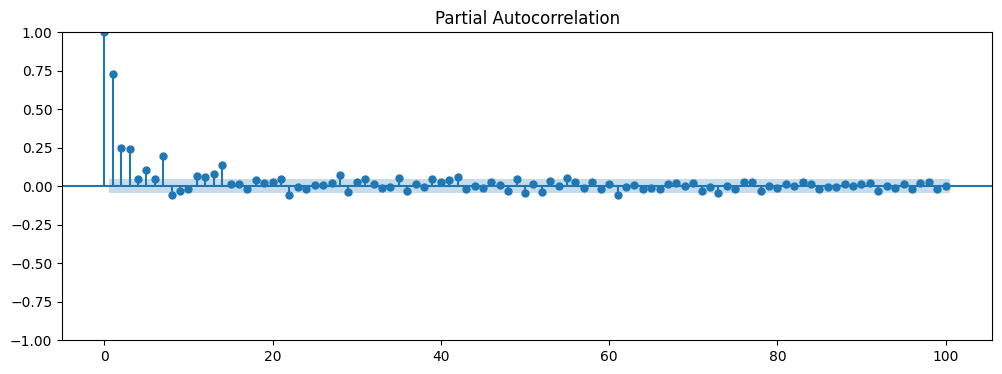

In [12]:
# Create the ACF and PACF plots

fig, ax = plt.subplots(figsize = (12,4))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

fig, ax = plt.subplots(figsize = (12,4))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()


# Lets look at stationarity...

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=None):

  # Run the ADF test
  result = adfuller(series.dropna(), autolag='AIC')

  # Extract and print results
  print('ADF Statistic:', result[0])
  print('p-value:', result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print(f'   {key}: {value}')

  # Interpretation
  if result[1] < 0.05:
      print("Result: The series is likely stationary (reject H0).")
  else:
      print("Result: The series is likely non-stationary (fail to reject H0).")


In [14]:
adf_test(df['y'])

ADF Statistic: -2.558399532351394
p-value: 0.10190360862386094
Critical Values:
   1%: -3.4340436225819664
   5%: -2.8631715289228103
   10%: -2.567638575476797
Result: The series is likely non-stationary (fail to reject H0).


Let's compute the difference `df.y`

In [15]:
df['y_diff'] = df['y'].diff().dropna()
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,0.3427,0.0109,NaN
2018-01-02,8922076.0,0.3087,0.0108,2651237.0
2018-01-03,8446101.0,0.2811,0.0101,-475975.0
2018-01-04,7785798.0,0.2732,0.0096,-660303.0
2018-01-05,6375303.0,0.2570,0.0090,-1410495.0


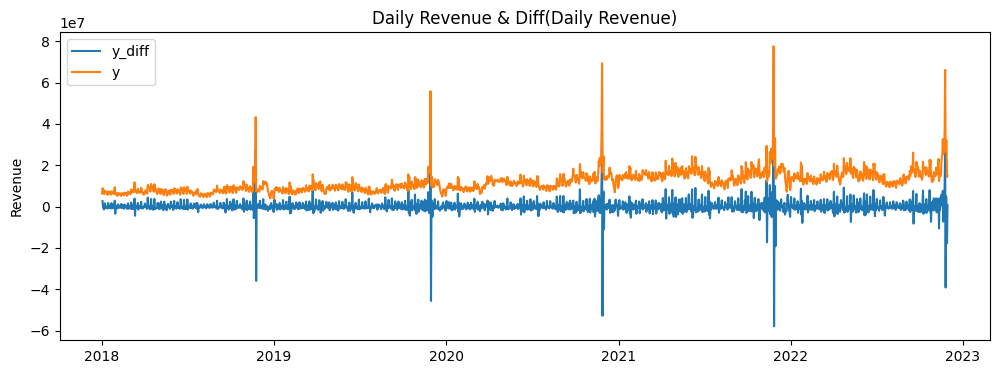

In [16]:
plt.figure(figsize = (12,4))
plt.plot(df['y_diff'],label='y_diff')
plt.plot(df['y'],label='y')
plt.legend()
plt.title("Daily Revenue & Diff(Daily Revenue)")
plt.ylabel("Revenue")
plt.show()

In [17]:
adf_test(df['y_diff'])

ADF Statistic: -12.808786916715999
p-value: 6.513792026816299e-24
Critical Values:
   1%: -3.4340436225819664
   5%: -2.8631715289228103
   10%: -2.567638575476797
Result: The series is likely stationary (reject H0).


# ARIMA Model

In [18]:
# Split the time series into train and test datasets

test_days = 30
train = df['y'][:-test_days]
test = df['y'][-test_days:]


In [19]:
train.tail()

,y
date,
2022-10-27,13714667.0
2022-10-28,12100780.0
2022-10-29,11849363.0
2022-10-30,14561144.0
2022-10-31,12689026.0


In [20]:
test.head()

,y
date,
2022-11-01,16703680.0
2022-11-02,15827022.0
2022-11-03,16154319.0
2022-11-04,14707212.0
2022-11-05,14877530.0


We will use the `pmdarima` package for the ARIMA model

In [21]:
model = auto_arima(train,seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Fri, 11 Jul 2025   AIC                          57650.535
Time:                        20:26:14   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.35e+42. Standard errors may be unstable.
"""

In [22]:
predictions = model.predict(n_periods=test_days)
predictions

,0
2022-11-01,1.445299e+07
2022-11-02,1.474103e+07
2022-11-03,1.503283e+07
2022-11-04,1.527520e+07
2022-11-05,1.534078e+07
2022-11-06,1.553442e+07
2022-11-07,1.554542e+07
2022-11-08,1.563967e+07
2022-11-09,1.565016e+07
2022-11-10,1.569221e+07


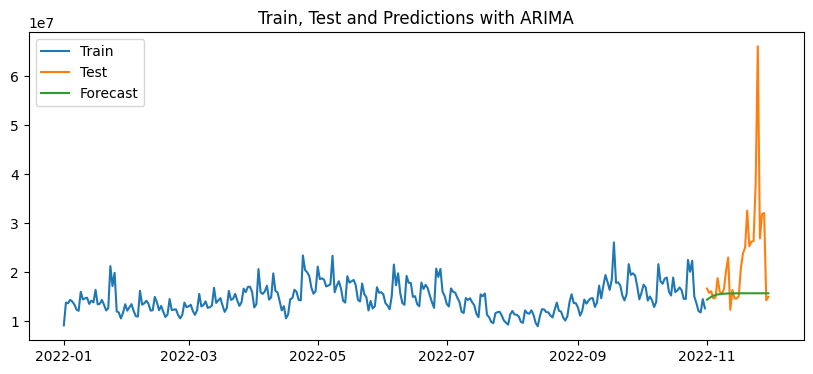

The MAE is 7267306.02
The RMSE is 12366038.29
The MAPE is 24.15 %


In [23]:
model_assessment(train.loc['2022'], test, predictions, "ARIMA")

# SARIMA

In [27]:
model = auto_arima(train,seasonal=True,m=7)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Fri, 11 Jul 2025   AIC                          57546.103
Time:                                   20:42:32   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4682.866      2.150      0.032     890.069    1.92e+04
ar.L1         -0.3476      0.072     -4.798      0.000      -0.490      -0.206
ar.L2          0.1857      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8712      0.172      5.071      0.000       0.535       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848640.85
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+31. Standard errors may be unstable.
"""

In [30]:
predictions = model.predict(n_periods=test_days)

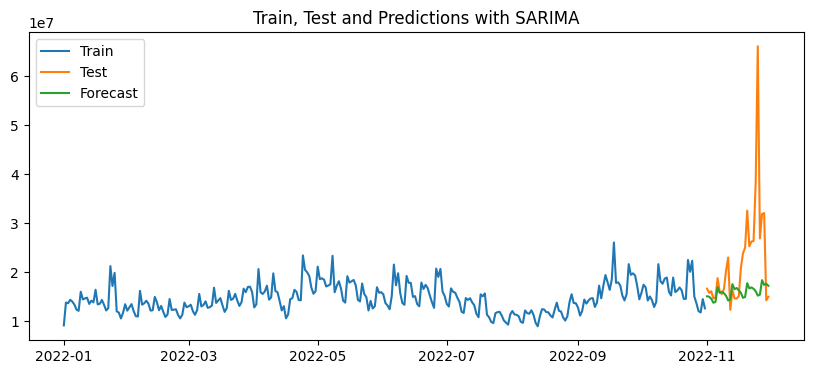

The MAE is 7210552.64
The RMSE is 12152397.97
The MAPE is 24.54 %


In [31]:
model_assessment(train.loc['2022'], test, predictions, "SARIMA")